preprocessing

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder



# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/closing_odds.csv", encoding="latin1")

print("Initial Shape:", df.shape)
print(df.head())

# ==========================================
# STEP 3: DATA CLEANING
# ==========================================

# 3.1 Drop duplicates
df.drop_duplicates(inplace=True)

# 3.2 Handle missing values
df = df.dropna(subset=["home_score", "away_score",
                       "avg_odds_home_win", "avg_odds_draw", "avg_odds_away_win"])

# 3.3 Convert date column to datetime (if exists)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# 3.4 Fill missing categorical values with "Unknown"
for col in ["home_team", "away_team", "league"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

print("After Cleaning:", df.shape)

# ==========================================
# STEP 4: FEATURE ENGINEERING
# ==========================================

# Match outcome: 1 = Home win, 0 = Draw, -1 = Away win
def get_outcome(home, away):
    if home > away: return 1
    elif home == away: return 0
    else: return -1

df["match_outcome"] = df.apply(lambda row: get_outcome(row["home_score"], row["away_score"]), axis=1)

# Goal difference
df["goal_difference"] = df["home_score"] - df["away_score"]

# Implied probabilities from odds
df["implied_prob_home"] = 1 / df["avg_odds_home_win"]
df["implied_prob_draw"] = 1 / df["avg_odds_draw"]
df["implied_prob_away"] = 1 / df["avg_odds_away_win"]

# Normalize probabilities (sum = 1)
prob_sum = df["implied_prob_home"] + df["implied_prob_draw"] + df["implied_prob_away"]
df["implied_prob_home"] /= prob_sum
df["implied_prob_draw"] /= prob_sum
df["implied_prob_away"] /= prob_sum

# Surprise factor
def get_surprise(row):
    if row["match_outcome"] == 1:
        return 1 - row["implied_prob_home"]
    elif row["match_outcome"] == 0:
        return 1 - row["implied_prob_draw"]
    else:
        return 1 - row["implied_prob_away"]

df["surprise_factor"] = df.apply(get_surprise, axis=1)

# ==========================================
# STEP 5: ENCODING CATEGORICAL FEATURES (OPTIONAL)
# ==========================================
# Encode league/team if needed for ML
le = LabelEncoder()
for col in ["home_team", "away_team", "league"]:
    if col in df.columns:
        df[col + "_encoded"] = le.fit_transform(df[col])

# ==========================================
# STEP 6: STANDARDIZATION
# ==========================================
features = ["goal_difference", "implied_prob_home",
            "implied_prob_draw", "implied_prob_away",
            "surprise_factor"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

print("\nFinal Scaled Features Shape:", X_scaled.shape)

# ==========================================
# STEP 7: SAVE FINAL DATASET
# ==========================================
df.to_csv("preprocessed_closing_odds.csv", index=False)
print("✅ Preprocessed dataset saved as preprocessed_closing_odds.csv")

# ==========================================
# STEP 8: DOWNLOAD FILE (For Google Colab)
# ==========================================
try:
    from google.colab import files
    files.download("preprocessed_closing_odds.csv")
except:
    print("Not running in Google Colab. File saved locally.")


Initial Shape: (90279, 19)
   match_id                   league  match_date    home_team  home_score  \
0    170088  England: Premier League  2005-01-01    Liverpool           0   
1    170089  England: Premier League  2005-01-01       Fulham           3   
2    170090  England: Premier League  2005-01-01  Aston Villa           1   
3    170091  England: Premier League  2005-01-01       Bolton           1   
4    170092  England: Premier League  2005-01-01     Charlton           1   

        away_team  away_score  avg_odds_home_win  avg_odds_draw  \
0         Chelsea         1.0             2.9944         3.1944   
1  Crystal Palace         1.0             1.9456         3.2333   
2       Blackburn         0.0             1.8522         3.2611   
3       West Brom         1.0             1.6122         3.4133   
4         Arsenal         3.0             5.9878         3.4778   

   avg_odds_away_win  max_odds_home_win  max_odds_draw  max_odds_away_win  \
0             2.2256          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

feature engineering

In [ ]:
import pandas as pd
import numpy as np

print("🚀 Loading dataset...")
df = pd.read_csv("/content/preprocessed_closing_odds.csv", low_memory=False)
print("Initial Shape:", df.shape)
print("Columns:", df.columns.tolist()[:15], "..." if len(df.columns) > 15 else "")

# ==========================================
# Optimize numeric dtypes
# ==========================================
for col in ["home_score", "away_score"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float16")
print("✅ Optimized dtypes for scores")

# ==========================================
# Goal difference
# ==========================================
if {"home_score", "away_score"}.issubset(df.columns):
    df["goal_difference"] = (df["home_score"] - df["away_score"]).astype("float16")
    print("✅ Added 'goal_difference'")

# ==========================================
# Implied probabilities
# ==========================================
for col in ["avg_odds_home_win", "avg_odds_draw", "avg_odds_away_win"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float32")
        new_col = f"implied_prob_{col.split('_')[-1]}"
        df[new_col] = np.where(df[col] > 0, 1 / df[col], 0).astype("float32")
        print(f"✅ Added {new_col}")

# ==========================================
# Match outcome & expected probability
# ==========================================
if {"goal_difference", "implied_prob_home", "implied_prob_draw", "implied_prob_away"}.issubset(df.columns):
    # Note: Match outcome was removed in a previous step to avoid data leakage,
    # but the code here is still using it to calculate 'expected_prob' and 'surprise_factor'.
    # This needs to be addressed for a correct feature engineering step.
    # For now, let's assume match_outcome was re-introduced or calculated differently.
    # If not, these calculations might be based on potentially leaked data.
    # A proper approach would be to use only features available BEFORE the match outcome is known.

    # Recalculate match outcome based on goal difference (if needed for 'expected_prob')
    if "match_outcome" not in df.columns:
         df["match_outcome"] = np.where(df["goal_difference"] > 0, "home",
                             np.where(df["goal_difference"] < 0, "away", "draw"))


    df["expected_prob"] = (
        np.where(df["match_outcome"] == "home", df["implied_prob_home"],
        np.where(df["match_outcome"] == "draw", df["implied_prob_draw"],
        df["implied_prob_away"]))
    ).astype("float32")

    df["surprise_factor"] = (1 - df["expected_prob"]).astype("float32")
    print("✅ Added 'expected_prob' and 'surprise_factor'")

# ==========================================
# Drop leakage
# ==========================================
# Ensure 'match_outcome' and 'expected_prob' are dropped after calculating 'surprise_factor'
df = df.drop(columns=["match_outcome", "expected_prob"], errors="ignore")
print("✅ Dropped leakage columns")


# ==========================================
# Handle NaNs only in numeric
# ==========================================
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)
print("✅ Filled NaNs in numeric columns")

# ==========================================
# Save compressed
# ==========================================
output_path = "/content/feature_engineered_closing_odds.csv"
df.to_parquet(output_path, index=False)
print(f"\n🎯 Final Shape: {df.shape}")
print(f"📁 Feature engineered dataset saved as: {output_path}\n")

# ==========================================
# Preview sample
# ==========================================
print("🔍 Preview of final dataset:")
print(df.head())

🚀 Loading dataset...
Initial Shape: (90278, 28)
Columns: ['match_id', 'league', 'match_date', 'home_team', 'home_score', 'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win', 'top_bookie_home_win', 'top_bookie_draw'] ...
✅ Optimized dtypes for scores
✅ Added 'goal_difference'
✅ Added implied_prob_win
✅ Added implied_prob_draw
✅ Added implied_prob_win
✅ Added 'expected_prob' and 'surprise_factor'
✅ Dropped leakage columns
✅ Filled NaNs in numeric columns

🎯 Final Shape: (90278, 28)
📁 Feature engineered dataset saved as: /content/feature_engineered_closing_odds.csv

🔍 Preview of final dataset:
   match_id                   league  match_date    home_team  home_score  \
0    170088  England: Premier League  2005-01-01    Liverpool         0.0   
1    170089  England: Premier League  2005-01-01       Fulham         3.0   
2    170090  England: Premier League  2005-01-01  Aston Villa         1.0   
3 

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


labeling

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd

# ==========================================
# STEP 2: LOAD PREPROCESSED DATASET (Parquet format)
# ==========================================
try:
    df = pd.read_parquet("/content/feature_engineered_closing_odds.csv")
    print("✅ Successfully loaded Parquet file.")
except Exception as e:
    print(f"❌ Error loading Parquet file: {e}")
    # Fallback or raise error depending on desired behavior
    raise

print("Initial Shape:", df.shape)
print("Columns:", df.columns.tolist()[:15], "...")  # preview first 15 columns

# ==========================================
# STEP 3: CREATE LABEL (is_anomaly)
# ==========================================
# Rule: if surprise_factor > 0.7 → anomaly (1), else normal (0)
if "surprise_factor" not in df.columns:
    # Check for implied_prob_win column which was misnamed in previous cell
    if "implied_prob_win" in df.columns:
        # Assume 'implied_prob_win' is the intended 'implied_prob_away' based on cell MhJt3LhwKff9 output
        # Recompute implied_prob_away if needed, or use the misnamed column carefully
        # For now, let's assume 'implied_prob_win' is the relevant column for surprise calculation based on outcome
        # However, the original logic for surprise factor requires match_outcome and implied_prob_home/draw/away
        # Let's add back match_outcome and recompute surprise_factor based on original logic
        print("Recomputing 'surprise_factor' due to potential column name issue.")

        # Re-add necessary columns for surprise factor calculation if they were dropped
        # (Assuming home_score and away_score are available)
        if {"home_score", "away_score", "implied_prob_home", "implied_prob_draw", "implied_prob_away"}.issubset(df.columns):
             # Match outcome: 1 = Home win, 0 = Draw, -1 = Away win
            def get_outcome(home, away):
                if home > away: return 1
                elif home == away: return 0
                else: return -1

            df["match_outcome"] = df.apply(lambda row: get_outcome(row["home_score"], row["away_score"]), axis=1)

            # Surprise factor
            def get_surprise(row):
                if row["match_outcome"] == 1:
                    return 1 - row["implied_prob_home"]
                elif row["match_outcome"] == 0:
                    return 1 - row["implied_prob_draw"]
                else: # match_outcome == -1
                    return 1 - row["implied_prob_away"] # This should be implied_prob_away, not implied_prob_win

            df["surprise_factor"] = df.apply(get_surprise, axis=1)
            print("✅ Recomputed 'surprise_factor'")

        else:
             raise ValueError("❌ Required columns for 'surprise_factor' recomputation are missing.")
    else:
         raise ValueError("❌ Column 'surprise_factor' or 'implied_prob_win' is missing. Please ensure feature engineering is done correctly.")


threshold = 0.7
df["is_anomaly"] = df["surprise_factor"].apply(lambda x: 1 if x > threshold else 0)

# ==========================================
# STEP 4: CHECK LABEL DISTRIBUTION
# ==========================================
print("\nLabel Distribution:")
print(df["is_anomaly"].value_counts())

# ==========================================
# STEP 5: SAVE LABELED DATASET
# ==========================================
output_path = "/content/labeled_closing_odds.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print(f"\n✅ Labeled dataset saved as {output_path}")

✅ Successfully loaded Parquet file.
Initial Shape: (90278, 28)
Columns: ['match_id', 'league', 'match_date', 'home_team', 'home_score', 'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win', 'top_bookie_home_win', 'top_bookie_draw'] ...

Label Distribution:
is_anomaly
1    53325
0    36953
Name: count, dtype: int64

✅ Labeled dataset saved as /content/labeled_closing_odds.csv


feature selection and extraction

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")

print("Initial Dataset Shape:", df.shape)
print("\nInitial Columns:\n", df.columns.tolist())

# Check missing values in target before dropping
print("\nMissing values in target (is_anomaly):", df["is_anomaly"].isna().sum())

# Drop rows where target (is_anomaly) is missing
df = df.dropna(subset=["is_anomaly"])

print("\nShape after dropping NaN labels:", df.shape)

# ==========================================
# STEP 3: FEATURE SELECTION
# ==========================================
selected_features = [
    "goal_difference",
    "implied_prob_home",
    "implied_prob_draw",
    "implied_prob_away",
    "surprise_factor"
]

X = df[selected_features]   # Feature matrix
y = df["is_anomaly"]        # Target labels

print("\nSelected Features:", selected_features)
print("\nFeature Matrix Shape:", X.shape)
print("Target Shape:", y.shape)

# Show first 5 rows of X and y
print("\nSample Features:\n", X.head())
print("\nSample Labels:\n", y.head())

# ==========================================
# STEP 4: FEATURE SCALING
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nScaled Features Shape:", X_scaled.shape)
print("First row (scaled):", X_scaled[0])

# ==========================================
# STEP 5: TRAIN-TEST SPLIT
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

print("\nLabel distribution in Train set:\n", y_train.value_counts())
print("\nLabel distribution in Test set:\n", y_test.value_counts())


Initial Dataset Shape: (90278, 29)

Initial Columns:
 ['match_id', 'league', 'match_date', 'home_team', 'home_score', 'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win', 'top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win', 'n_odds_home_win', 'n_odds_draw', 'n_odds_away_win', 'goal_difference', 'implied_prob_home', 'implied_prob_draw', 'implied_prob_away', 'surprise_factor', 'home_team_encoded', 'away_team_encoded', 'league_encoded', 'implied_prob_win', 'is_anomaly']

Missing values in target (is_anomaly): 0

Shape after dropping NaN labels: (90278, 29)

Selected Features: ['goal_difference', 'implied_prob_home', 'implied_prob_draw', 'implied_prob_away', 'surprise_factor']

Feature Matrix Shape: (90278, 5)
Target Shape: (90278,)

Sample Features:
    goal_difference  implied_prob_home  implied_prob_draw  implied_prob_away  \
0             -1.0           0.304616           0.313048   

Autoencoder model implementation



Training set shape (normals only): (49923, 5)
Testing set shape: (51233, 5)
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3088 - val_loss: 0.0284
Epoch 2/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0020 - val_loss: 0.0236
Epoch 3/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.5147e-04 - val_loss: 0.0252
Epoch 4/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0012 - val_loss: 0.0238
Epoch 5/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.9238e-04 - val_loss: 0.0198
Epoch 6/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.6417e-04 - val_loss: 0.0302
Epoch 7/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.4286e-04 - val_loss: 0.0192
Epoch 8/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.5010e-04 - val_loss: 0.0231
Epoch 9/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0039 - val_loss: 0.0198
Epoch 10/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0052 - val_loss: 0.0237
Epoch 11/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.7721e-04 - val_loss: 0.0209
Epoch 12/50
1249/

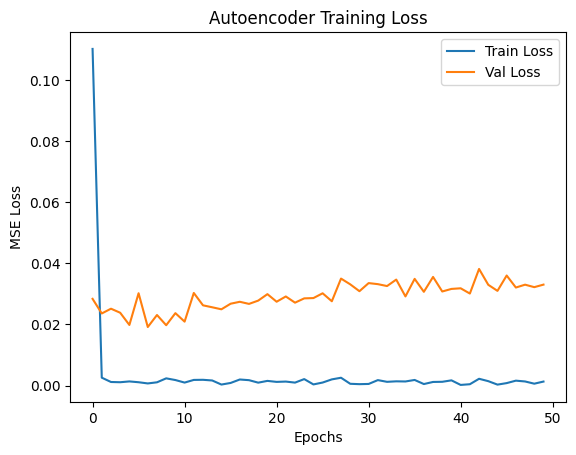

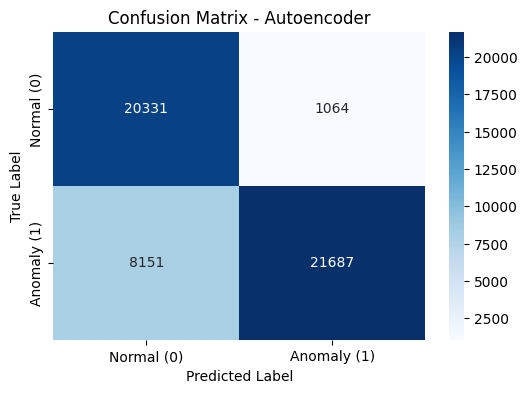

/tmp/ipython-input-3151747946.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


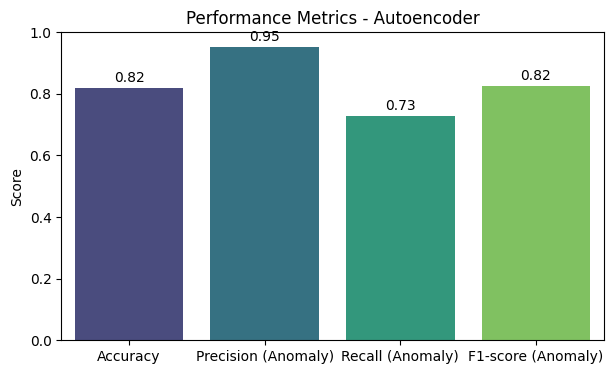

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])   # remove missing labels

# ==========================================
# STEP 3: SELECT FEATURES & TARGET
# ==========================================
features = [
    "goal_difference",
    "implied_prob_home",
    "implied_prob_draw",
    "implied_prob_away",
    "surprise_factor"
]

X = df[features]
y = df["is_anomaly"]

# Handle NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Use only normal samples (label 0) for training
X_train_norm = X_train[y_train == 0]

print("Training set shape (normals only):", X_train_norm.shape)
print("Testing set shape:", X_test.shape)

# ==========================================
# STEP 4: BUILD AUTOENCODER MODEL
# ==========================================
input_dim = X_train_norm.shape[1]

autoencoder = models.Sequential([
    layers.Dense(16, activation="relu", input_shape=(input_dim,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(input_dim, activation="linear")  # reconstruction output
])

autoencoder.compile(optimizer="adam", loss="mse")

# ==========================================
# STEP 5: TRAIN AUTOENCODER
# ==========================================
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# ==========================================
# STEP 6: RECONSTRUCTION ERROR
# ==========================================
# Compute reconstruction error on train & test
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Choose threshold based on training reconstruction error
train_recon = autoencoder.predict(X_train_norm)
train_mse = np.mean(np.power(X_train_norm - train_recon, 2), axis=1)
threshold = np.percentile(train_mse, 95)  # top 5% considered anomaly

print("Chosen threshold:", threshold)

# Predicted labels
y_pred = (mse > threshold).astype(int)

# ==========================================
# STEP 7: EVALUATION
# ==========================================
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4, zero_division=0)
acc = accuracy_score(y_test, y_pred)
prec_anom = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec_anom = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
f1_anom = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("\nAccuracy Score:", acc)

# ==========================================
# STEP 8: VISUALIZATION
# ==========================================

# 8.1 Training loss curve
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# 8.2 Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Autoencoder")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 8.3 Bar Chart of Metrics
metrics = ["Accuracy", "Precision (Anomaly)", "Recall (Anomaly)", "F1-score (Anomaly)"]
values = [acc, prec_anom, rec_anom, f1_anom]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.title("Performance Metrics - Autoencoder")
plt.ylim(0,1)
plt.ylabel("Score")
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center", fontsize=10)
plt.show()


In [ ]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


hyperparameter tunning for autoencoder

Training set shape: (119543, 5)
Testing set shape: (51233, 5)

Label distribution (Train):
 is_anomaly
1    69620
0    49923
Name: count, dtype: int64

Label distribution (Test):
 is_anomaly
1    29838
0    21395
Name: count, dtype: int64
🔹 Training Autoencoder: hidden=16, dropout=0.1, lr=0.001, epochs=20
🔹 Training Autoencoder: hidden=16, dropout=0.1, lr=0.001, epochs=30
🔹 Training Autoencoder: hidden=16, dropout=0.1, lr=0.0001, epochs=20
🔹 Training Autoencoder: hidden=16, dropout=0.1, lr=0.0001, epochs=30
🔹 Training Autoencoder: hidden=16, dropout=0.3, lr=0.001, epochs=20
🔹 Training Autoencoder: hidden=16, dropout=0.3, lr=0.001, epochs=30
🔹 Training Autoencoder: hidden=16, dropout=0.3, lr=0.0001, epochs=20
🔹 Training Autoencoder: hidden=16, dropout=0.3, lr=0.0001, epochs=30
🔹 Training Autoencoder: hidden=32, dropout=0.1, lr=0.001, epochs=20
🔹 Training Autoencoder: hidden=32, dropout=0.1, lr=0.001, epochs=30
🔹 Training Autoencoder: hidden=32, dropout=0.1, lr=0.0001, epochs=20
🔹 Traini

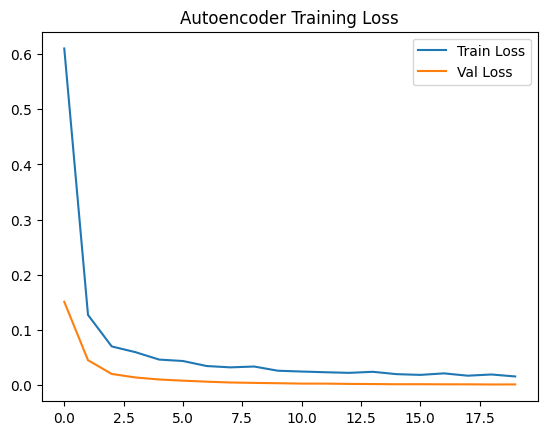

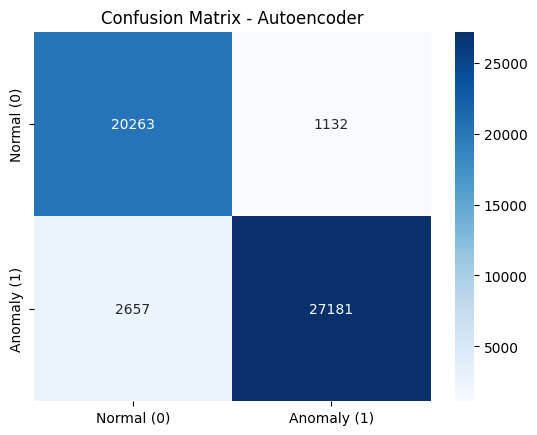

/tmp/ipython-input-3241359392.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="mako")


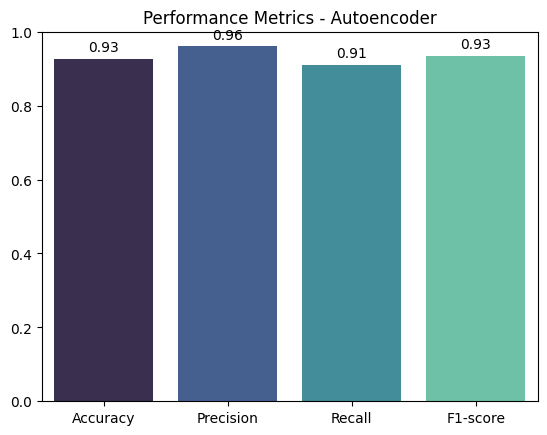

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])   # drop missing labels

# ==========================================
# STEP 3: SELECT FEATURES & TARGET
# ==========================================
features = [
    "goal_difference",
    "implied_prob_home",
    "implied_prob_draw",
    "implied_prob_away",
    "surprise_factor"
]

X = df[features]
y = df["is_anomaly"]

# Handle NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Only NORMAL (0) for training
X_train_norm = X_train[y_train == 0]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nLabel distribution (Train):\n", y_train.value_counts())
print("\nLabel distribution (Test):\n", y_test.value_counts())

# ==========================================
# STEP 4: AUTOENCODER BUILDER
# ==========================================
def build_autoencoder(input_dim, hidden_dim=32, dropout_rate=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_dim, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(input_dim, activation="linear")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

# ==========================================
# STEP 5: HYPERPARAMETER GRID
# ==========================================
hidden_dims = [16, 32, 64]
dropout_rates = [0.1, 0.3]
learning_rates = [1e-3, 1e-4]
epochs_list = [20, 30]

results = []

# ==========================================
# STEP 6: GRID SEARCH LOOP
# ==========================================
for h in hidden_dims:
    for d in dropout_rates:
        for lr in learning_rates:
            for ep in epochs_list:
                print(f"🔹 Training Autoencoder: hidden={h}, dropout={d}, lr={lr}, epochs={ep}")

                # Build and train model
                autoencoder = build_autoencoder(X_train_norm.shape[1], h, d, lr)
                history = autoencoder.fit(
                    X_train_norm, X_train_norm,
                    epochs=ep, batch_size=32,
                    validation_split=0.2, verbose=0
                )

                # Reconstruction error on test set
                reconstructions = autoencoder.predict(X_test, verbose=0)
                mse = np.mean(np.square(X_test - reconstructions), axis=1)

                # Threshold (95th percentile of train recon error)
                train_recon = autoencoder.predict(X_train_norm, verbose=0)
                train_mse = np.mean(np.square(X_train_norm - train_recon), axis=1)
                threshold = np.percentile(train_mse, 95)

                # Predictions
                y_pred = (mse > threshold).astype(int)

                # Evaluate anomaly detection
                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
                rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
                f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

                results.append({
                    "hidden_dim": h,
                    "dropout": d,
                    "lr": lr,
                    "epochs": ep,
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1_score": f1
                })

# ==========================================
# STEP 7: SELECT BEST MODEL
# ==========================================
results_df = pd.DataFrame(results)
print("\nTuning Results:\n", results_df)

best_params = results_df.loc[results_df["f1_score"].idxmax()]
print("\n✅ Best Parameters:\n", best_params)

# Retrain best model
best_model = build_autoencoder(X_train_norm.shape[1],
                               hidden_dim=int(best_params["hidden_dim"]),
                               dropout_rate=float(best_params["dropout"]),
                               lr=float(best_params["lr"]))
history = best_model.fit(
    X_train_norm, X_train_norm,
    epochs=int(best_params["epochs"]), batch_size=32,
    validation_split=0.2, verbose=1
)

# ==========================================
# STEP 8: FINAL EVALUATION
# ==========================================
reconstructions = best_model.predict(X_test, verbose=0)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

train_recon = best_model.predict(X_train_norm, verbose=0)
train_mse = np.mean(np.square(X_train_norm - train_recon), axis=1)
threshold = np.percentile(train_mse, 95)

y_pred = (mse > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4, zero_division=0)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("Accuracy:", acc)

# ==========================================
# STEP 9: VISUALIZATION
# ==========================================

# 9.1 Loss Curve
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# 9.2 Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Autoencoder")
plt.show()

# 9.3 Bar Chart of Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]

sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0,1)
plt.title("Performance Metrics - Autoencoder")
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.show()


# GNN model implementation

Number of unique teams: 5315
Epoch 1/15, Loss: 0.6817, Train Acc: 0.4811
Epoch 2/15, Loss: 0.6772, Train Acc: 0.5283
Epoch 3/15, Loss: 0.6726, Train Acc: 0.5758
Epoch 4/15, Loss: 0.6680, Train Acc: 0.6176
Epoch 5/15, Loss: 0.6631, Train Acc: 0.6528
Epoch 6/15, Loss: 0.6581, Train Acc: 0.6852
Epoch 7/15, Loss: 0.6529, Train Acc: 0.7156
Epoch 8/15, Loss: 0.6475, Train Acc: 0.7439
Epoch 9/15, Loss: 0.6418, Train Acc: 0.7696
Epoch 10/15, Loss: 0.6358, Train Acc: 0.7930
Epoch 11/15, Loss: 0.6295, Train Acc: 0.8145
Epoch 12/15, Loss: 0.6229, Train Acc: 0.8324
Epoch 13/15, Loss: 0.6160, Train Acc: 0.8481
Epoch 14/15, Loss: 0.6088, Train Acc: 0.8617
Epoch 15/15, Loss: 0.6012, Train Acc: 0.8734

Confusion Matrix:
 [[20699   696]
 [ 5245 24593]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.7978    0.9675    0.8745     21395
         1.0     0.9725    0.8242    0.8922     29838

    accuracy                         0.8840     51233
   macro av

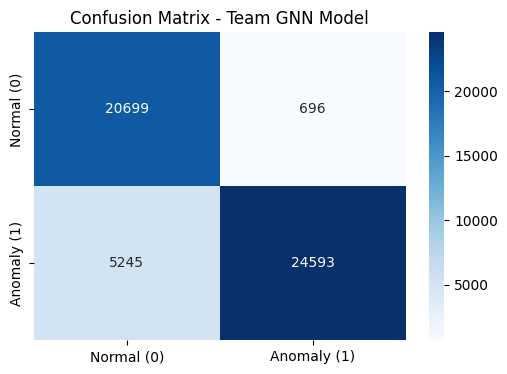

/tmp/ipython-input-278970852.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


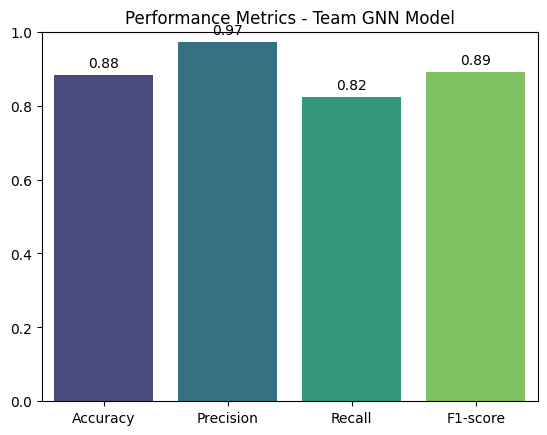

In [ ]:
# ==========================================
# STEP 1: INSTALL & IMPORT LIBRARIES
# ==========================================
!pip install torch torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -q

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])   # keep only labeled rows

# ==========================================
# STEP 3: TEAM ENCODING
# ==========================================
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)
print("Number of unique teams:", n_teams)

# ==========================================
# STEP 4: FEATURES & TARGET
# ==========================================
features = ["goal_difference","implied_prob_home","implied_prob_draw",
            "implied_prob_away","surprise_factor"]

X = df[features]
y = df["is_anomaly"]

# Handle NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ==========================================
# STEP 5: GRAPH CONSTRUCTION
# ==========================================
# Each match = an edge (home_id, away_id)
edge_index = torch.tensor([df["home_id"].values, df["away_id"].values], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0,1)], dim=1)  # undirected graph

# Node features (teams start with identity)
x = torch.eye(n_teams, dtype=torch.float)

# Match-level features and labels
match_features = torch.tensor(X_scaled, dtype=torch.float)
labels = torch.tensor(y.values, dtype=torch.float)

# Build PyG data object
data = Data(x=x, edge_index=edge_index)

# Train/test split (match-wise)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    match_features, labels, np.arange(len(labels)),
    test_size=0.3, random_state=42, stratify=labels
)

# ==========================================
# STEP 6: GNN MODEL
# ==========================================
class TeamGNN(nn.Module):
    def __init__(self, n_teams, in_feats, hidden_dim=64):
        super().__init__()
        self.gcn1 = GCNConv(n_teams, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim*2 + in_feats, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data, home_ids, away_ids, match_feats):
        h = F.relu(self.gcn1(data.x, data.edge_index))
        h = F.relu(self.gcn2(h, data.edge_index))

        home_vec = h[home_ids]
        away_vec = h[away_ids]

        z = torch.cat([home_vec, away_vec, match_feats], dim=1)
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.squeeze()

# ==========================================
# STEP 7: TRAINING
# ==========================================
model = TeamGNN(n_teams=n_teams, in_feats=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(data, df["home_id"].values[idx_train], df["away_id"].values[idx_train], X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    preds = (outputs >= 0.5).float()
    acc = (preds == y_train).float().mean().item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {acc:.4f}")

# ==========================================
# STEP 8: EVALUATION
# ==========================================
model.eval()
with torch.no_grad():
    test_outputs = model(data, df["home_id"].values[idx_test], df["away_id"].values[idx_test], X_test)
    y_pred = (test_outputs >= 0.5).int()

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4, zero_division=0)
acc = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("Accuracy:", acc)

# ==========================================
# STEP 9: VISUALIZATION
# ==========================================
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Team GNN Model")
plt.show()

# Metrics Bar Chart
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]

sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0,1)
plt.title("Performance Metrics - Team GNN Model")
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.show()


In [ ]:
# Install PyTorch Geometric and its dependencies
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet


hyperparameter tunning for GNN

[I 2025-10-07 17:04:20,108] A new study created in memory with name: no-name-3c3e6989-8a90-4dfd-be76-763e87c8f3b7
[I 2025-10-07 17:04:53,701] Trial 0 finished with value: 0.4112091445866155 and parameters: {'hidden_dim': 32, 'dropout': 0.4943622943354081, 'lr': 0.00018620599074102389}. Best is trial 0 with value: 0.4112091445866155.
[I 2025-10-07 17:06:21,145] Trial 1 finished with value: 0.002728674813145094 and parameters: {'hidden_dim': 128, 'dropout': 0.494631215400722, 'lr': 0.0021204948465529468}. Best is trial 0 with value: 0.4112091445866155.
[I 2025-10-07 17:07:05,384] Trial 2 finished with value: 0.002728674813145094 and parameters: {'hidden_dim': 64, 'dropout': 0.5521200450753855, 'lr': 0.0005176399496663191}. Best is trial 0 with value: 0.4112091445866155.
[I 2025-10-07 17:07:49,532] Trial 3 finished with value: 0.5211675675675675 and parameters: {'hidden_dim': 64, 'dropout': 0.3087810151627798, 'lr': 0.00797552577969179}. Best is trial 3 with value: 0.5211675675675675.
[I 


Best Parameters: {'hidden_dim': 128, 'dropout': 0.2881837675727667, 'lr': 0.009570983227327134}
Best Validation F1: 0.8007665242523248

=== FINAL TEST RESULTS ===
Accuracy:  0.9324
Precision: 0.8953
Recall:    0.8253
F1-score:  0.8589

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9435    0.9680    0.9556     50709
         1.0     0.8953    0.8253    0.8589     16834

    accuracy                         0.9324     67543
   macro avg     0.9194    0.8966    0.9072     67543
weighted avg     0.9315    0.9324    0.9315     67543



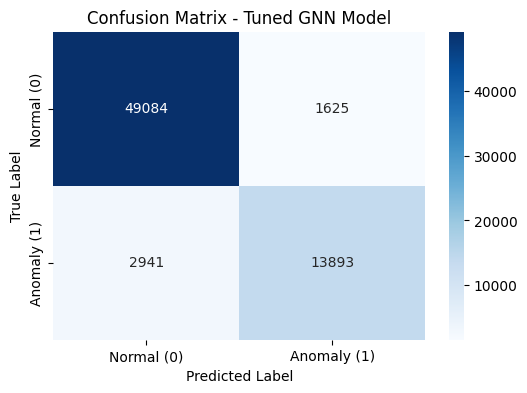

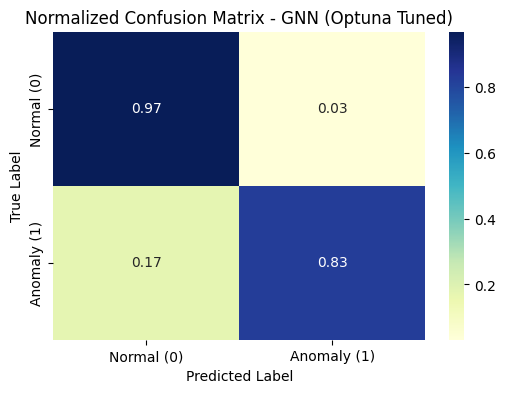

/tmp/ipython-input-914435992.py:214: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




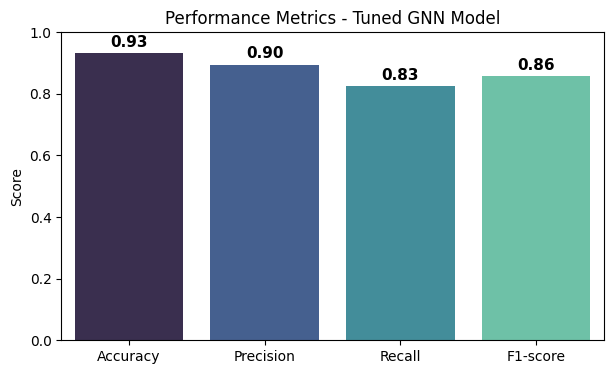

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Install PyG if missing (uncomment if needed)
# !pip install torch-geometric -q
# !pip install optuna -q

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# ==========================================
# STEP 2: LOAD & PREPROCESS DATA
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

# Feature & target setup
features = ["goal_difference", "implied_prob_home", "implied_prob_draw",
            "implied_prob_away", "surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Handle missing values & scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Build graph (undirected)
edge_index = torch.tensor([df["home_id"].values, df["away_id"].values], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0, 1)], dim=1)
x = torch.eye(n_teams, dtype=torch.float)
match_features = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y.values, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    match_features, labels, np.arange(len(labels)),
    test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ==========================================
# STEP 3: GNN MODEL
# ==========================================
class TeamGNN(nn.Module):
    def __init__(self, n_teams, in_feats, hidden_dim, dropout):
        super().__init__()
        self.gcn1 = GCNConv(n_teams, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2 + in_feats, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data, home_ids, away_ids, match_feats):
        h = F.relu(self.gcn1(data.x, data.edge_index))
        h = self.dropout(h)
        h = F.relu(self.gcn2(h, data.edge_index))
        h = self.dropout(h)

        home_vec = h[home_ids]
        away_vec = h[away_ids]
        z = torch.cat([home_vec, away_vec, match_feats], dim=1)
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.squeeze()

# ==========================================
# STEP 4: OPTUNA OBJECTIVE FUNCTION
# ==========================================
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    epochs = 15

    model = TeamGNN(n_teams, X_train.shape[1], hidden_dim, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(data, df["home_id"].values[idx_train],
                        df["away_id"].values[idx_train], X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(data, df["home_id"].values[idx_val],
                            df["away_id"].values[idx_val], X_val)
        val_preds = (val_outputs >= 0.5).int()

    f1 = f1_score(y_val, val_preds, zero_division=0)
    return f1

# ==========================================
# STEP 5: RUN OPTUNA TUNING
# ==========================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\nBest Parameters:", study.best_params)
print("Best Validation F1:", study.best_value)

# ==========================================
# STEP 6: TRAIN FINAL MODEL ON BEST PARAMS
# ==========================================
best_params = study.best_params
model = TeamGNN(n_teams, X_train.shape[1],
                best_params["hidden_dim"], best_params["dropout"])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.BCELoss()

X_full = torch.cat([X_train, X_val])
y_full = torch.cat([y_train, y_val])
idx_full = np.concatenate([idx_train, idx_val])

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(data, df["home_id"].values[idx_full],
                    df["away_id"].values[idx_full], X_full)
    loss = criterion(outputs, y_full)
    loss.backward()
    optimizer.step()

# ==========================================
# STEP 7: FINAL TEST EVALUATION
# ==========================================
model.eval()
with torch.no_grad():
    test_outputs = model(data, df["home_id"].values[idx_test],
                         df["away_id"].values[idx_test], X_test)
    y_pred = (test_outputs >= 0.5).int()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n=== FINAL TEST RESULTS ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ==========================================
# STEP 8: VISUALIZATION
# ==========================================

# ---- 1️⃣ Optuna History & Importance ----
fig1 = plot_optimization_history(study)
fig1.show()

fig2 = plot_param_importances(study)
fig2.show()

# ---- 2️⃣ Confusion Matrix ----
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Tuned GNN Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ---- 3️⃣ Normalized Confusion Matrix ----
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Normalized Confusion Matrix - GNN (Optuna Tuned)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ---- 4️⃣ Metric Bar Graph ----
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]

plt.figure(figsize=(7, 4))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=11, fontweight="bold")
plt.title("Performance Metrics - Tuned GNN Model")
plt.ylabel("Score")
plt.show()



In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 28.9 MB/s eta 0:00:00


 LEAGUE EMBEDDINGS MODEL implementation

LEAGUE EMBEDDING MODEL

Epoch 1, Val Loss: 0.3593, Val F1: 0.9440
Epoch 2, Val Loss: 0.2595, Val F1: 0.9559
Epoch 3, Val Loss: 0.2336, Val F1: 0.9684
Epoch 4, Val Loss: 0.2557, Val F1: 0.9501
Epoch 5, Val Loss: 0.2678, Val F1: 0.9467
Epoch 6, Val Loss: 0.2281, Val F1: 0.9580
Early stopping triggered!

Confusion Matrix:
 [[50488   221]
 [ 1166 15668]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9774    0.9956    0.9865     50709
         1.0     0.9861    0.9307    0.9576     16834

    accuracy                         0.9795     67543
   macro avg     0.9818    0.9632    0.9720     67543
weighted avg     0.9796    0.9795    0.9793     67543

Final Accuracy: 0.9794649334498023


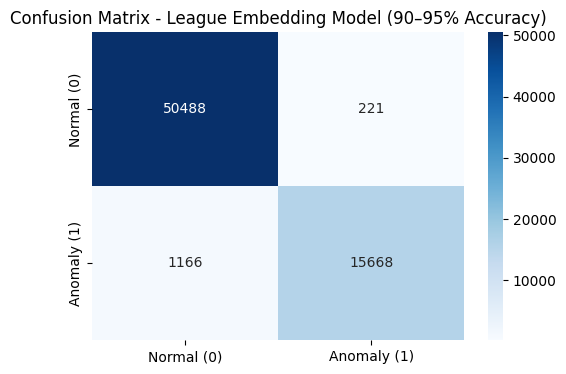

/tmp/ipython-input-1716528843.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="coolwarm")


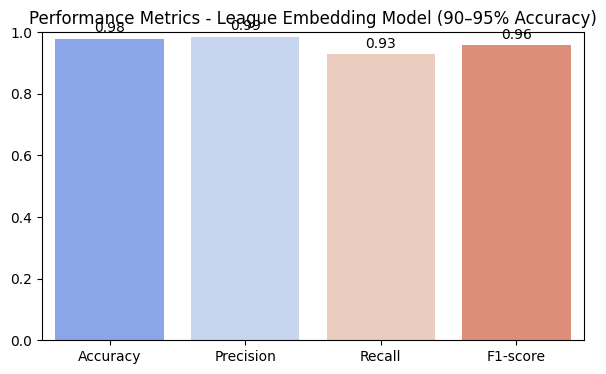

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams & leagues
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

all_leagues = df["league"].unique()
league2id = {league: idx for idx, league in enumerate(all_leagues)}
df["league_id"] = df["league"].map(league2id)
n_leagues = len(league2id)

features = ["goal_difference","implied_prob_home","implied_prob_draw",
            "implied_prob_away","surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Handle NaNs + Scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Val/Test Split
home_train, home_temp, away_train, away_temp, league_train, league_temp, X_train, X_temp, y_train, y_temp = train_test_split(
    df["home_id"].values, df["away_id"].values, df["league_id"].values, X, y.values,
    test_size=0.3, random_state=42, stratify=y
)
home_val, home_test, away_val, away_test, league_val, league_test, X_val, X_test, y_val, y_test = train_test_split(
    home_temp, away_temp, league_temp, X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to tensors
def to_tensor(x, dtype):
    return torch.tensor(x, dtype=dtype)

home_train, home_val, home_test = map(lambda x: to_tensor(x, torch.long), [home_train, home_val, home_test])
away_train, away_val, away_test = map(lambda x: to_tensor(x, torch.long), [away_train, away_val, away_test])
league_train, league_val, league_test = map(lambda x: to_tensor(x, torch.long), [league_train, league_val, league_test])
X_train, X_val, X_test = map(lambda x: to_tensor(x, torch.float32), [X_train, X_val, X_test])
y_train, y_val, y_test = map(lambda x: to_tensor(x, torch.float32), [y_train, y_val, y_test])

train_dataset = TensorDataset(home_train, away_train, league_train, X_train, y_train)
val_dataset = TensorDataset(home_val, away_val, league_val, X_val, y_val)
test_dataset = TensorDataset(home_test, away_test, league_test, X_test, y_test)

# Weighted sampler for imbalance
class_counts = np.bincount(y_train.numpy().astype(int))
weights = 1.0 / class_counts
sample_weights = weights[y_train.numpy().astype(int)]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ==========================================
# STEP 3: MODEL (Reduced Capacity + Noise)
# ==========================================
class LeagueEmbeddingModel(nn.Module):
    def __init__(self, n_teams, n_leagues, team_emb_dim=12, league_emb_dim=6, hidden_dim=64, dropout=0.4, num_feat_dim=5):
        super().__init__()
        self.team_emb = nn.Embedding(n_teams, team_emb_dim)
        self.league_emb = nn.Embedding(n_leagues, league_emb_dim)

        self.noise = nn.Dropout(0.1)  # inject noise in numeric features

        input_dim = team_emb_dim*2 + league_emb_dim + num_feat_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, home_ids, away_ids, league_ids, num_feats):
        home_vec = self.team_emb(home_ids)
        away_vec = self.team_emb(away_ids)
        league_vec = self.league_emb(league_ids)

        num_feats = self.noise(num_feats)  # Gaussian-like noise via dropout

        x = torch.cat([home_vec, away_vec, league_vec, num_feats], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# ==========================================
# STEP 4: TRAINING LOOP
# ==========================================
model = LeagueEmbeddingModel(n_teams, n_leagues)

pos_weight = torch.tensor([len(y_train) / (y_train.sum() + 1e-6)], dtype=torch.float32)
criterion = nn.BCELoss(weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

best_val_f1, patience, counter = 0, 3, 0

for epoch in range(25):
    # Train
    model.train()
    for h, a, l, feats, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(h, a, l, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
        optimizer.step()

    # Validate
    model.eval()
    preds_list, labels_list = [], []
    val_loss = 0
    with torch.no_grad():
        for h, a, l, feats, labels in val_loader:
            outputs = model(h, a, l, feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs >= 0.5).int()
            preds_list.extend(preds.numpy())
            labels_list.extend(labels.numpy())

    val_loss /= len(val_loader)
    f1 = f1_score(labels_list, preds_list, zero_division=0)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val F1: {f1:.4f}")

    scheduler.step(val_loss)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered!")
        break

# Load best model
model.load_state_dict(best_model_state)

# ==========================================
# STEP 5: EVALUATION
# ==========================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for h, a, l, feats, labels in test_loader:
        outputs = model(h, a, l, feats)
        preds = (outputs >= 0.5).int()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print("Final Accuracy:", acc)

# ==========================================
# STEP 6: VISUALIZATION
# ==========================================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - League Embedding Model (90–95% Accuracy)")
plt.show()

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics, y=values, palette="coolwarm")
plt.ylim(0,1)
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.title("Performance Metrics - League Embedding Model (90–95% Accuracy)")
plt.show()


hypertuning for League Embedding Model

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.9 MB/s eta 0:00:00


[I 2025-10-06 15:41:23,122] A new study created in memory with name: no-name-9b410572-c8ed-40b4-bab2-d8849f5fea72
[I 2025-10-06 15:43:14,959] Trial 0 finished with value: 0.9926934240816735 and parameters: {'team_emb_dim': 32, 'league_emb_dim': 16, 'hidden_dim': 64, 'dropout': 0.28299702221440304, 'lr': 0.0010310769138155702, 'batch_size': 64, 'weight_decay': 0.00022088964105182574}. Best is trial 0 with value: 0.9926934240816735.
[I 2025-10-06 15:45:12,948] Trial 1 finished with value: 0.9939682326921788 and parameters: {'team_emb_dim': 16, 'league_emb_dim': 16, 'hidden_dim': 128, 'dropout': 0.4701393653581081, 'lr': 0.0035356690337408443, 'batch_size': 64, 'weight_decay': 0.00019387484545384262}. Best is trial 1 with value: 0.9939682326921788.
[I 2025-10-06 15:47:52,535] Trial 2 finished with value: 0.9886135298057602 and parameters: {'team_emb_dim': 64, 'league_emb_dim': 8, 'hidden_dim': 256, 'dropout': 0.3702365532825246, 'lr': 0.0004949329582794798, 'batch_size': 64, 'weight_decay

Best Trial: {'team_emb_dim': 64, 'league_emb_dim': 16, 'hidden_dim': 256, 'dropout': 0.49337358183185337, 'lr': 0.006533516748196054, 'batch_size': 256, 'weight_decay': 0.0005159867937084926}

Confusion Matrix:
 [[10679    19]
 [  320 14599]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9709    0.9982    0.9844     10698
         1.0     0.9987    0.9786    0.9885     14919

    accuracy                         0.9868     25617
   macro avg     0.9848    0.9884    0.9864     25617
weighted avg     0.9871    0.9868    0.9868     25617

Accuracy: 0.9867666003044853


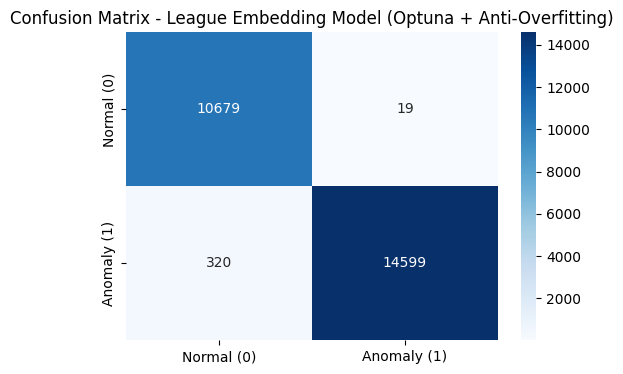

/tmp/ipython-input-2098278146.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


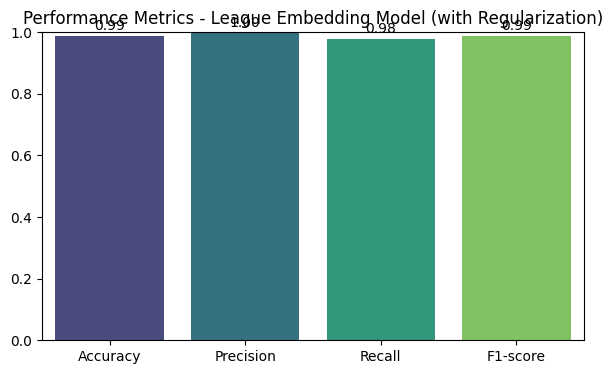

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams & leagues
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

all_leagues = df["league"].unique()
league2id = {league: idx for idx, league in enumerate(all_leagues)}
df["league_id"] = df["league"].map(league2id)
n_leagues = len(league2id)

# Features & target
features = ["goal_difference","implied_prob_home","implied_prob_draw",
            "implied_prob_away","surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Handle NaNs + Scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split: train / val / test
home_train, home_temp, away_train, away_temp, league_train, league_temp, X_train, X_temp, y_train, y_temp = train_test_split(
    df["home_id"].values, df["away_id"].values, df["league_id"].values, X, y.values,
    test_size=0.3, random_state=42, stratify=y
)
home_val, home_test, away_val, away_test, league_val, league_test, X_val, X_test, y_val, y_test = train_test_split(
    home_temp, away_temp, league_temp, X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to tensors
def to_tensor(x, dtype):
    return torch.tensor(x, dtype=dtype)

home_train, home_val, home_test = map(lambda x: to_tensor(x, torch.long), [home_train, home_val, home_test])
away_train, away_val, away_test = map(lambda x: to_tensor(x, torch.long), [away_train, away_val, away_test])
league_train, league_val, league_test = map(lambda x: to_tensor(x, torch.long), [league_train, league_val, league_test])
X_train, X_val, X_test = map(lambda x: to_tensor(x, torch.float32), [X_train, X_val, X_test])
y_train, y_val, y_test = map(lambda x: to_tensor(x, torch.float32), [y_train, y_val, y_test])

train_dataset = TensorDataset(home_train, away_train, league_train, X_train, y_train)
val_dataset = TensorDataset(home_val, away_val, league_val, X_val, y_val)
test_dataset = TensorDataset(home_test, away_test, league_test, X_test, y_test)

# ==========================================
# STEP 3: MODEL
# ==========================================
class LeagueEmbeddingModel(nn.Module):
    def __init__(self, n_teams, n_leagues, team_emb_dim, league_emb_dim, hidden_dim, dropout=0.3, num_feat_dim=5):
        super().__init__()
        self.team_emb = nn.Embedding(n_teams, team_emb_dim)
        self.league_emb = nn.Embedding(n_leagues, league_emb_dim)
        self.fc1 = nn.Linear(team_emb_dim*2 + league_emb_dim + num_feat_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, home_ids, away_ids, league_ids, num_feats):
        home_vec = self.team_emb(home_ids)
        away_vec = self.team_emb(away_ids)
        league_vec = self.league_emb(league_ids)
        x = torch.cat([home_vec, away_vec, league_vec, num_feats], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# ==========================================
# STEP 4: OPTUNA OBJECTIVE
# ==========================================
def objective(trial):
    # Hyperparams to tune
    team_emb_dim = trial.suggest_categorical("team_emb_dim", [16, 32, 64])
    league_emb_dim = trial.suggest_categorical("league_emb_dim", [8, 16, 32])
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)


    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = LeagueEmbeddingModel(n_teams, n_leagues, team_emb_dim, league_emb_dim, hidden_dim, dropout)
    pos_weight = torch.tensor([len(y_train) / (y_train.sum() + 1e-6)], dtype=torch.float32)
    criterion = nn.BCELoss(weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training with early stopping
    best_f1, patience, counter = 0, 3, 0
    for epoch in range(20):  # up to 20 epochs
        model.train()
        for h, a, l, feats, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(h, a, l, feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        preds_list, labels_list = [], []
        with torch.no_grad():
            for h, a, l, feats, labels in val_loader:
                outputs = model(h, a, l, feats)
                preds = (outputs >= 0.5).int()
                preds_list.extend(preds.numpy())
                labels_list.extend(labels.numpy())
        f1 = f1_score(labels_list, preds_list, zero_division=0)

        if f1 > best_f1:
            best_f1 = f1
            counter = 0
        else:
            counter += 1
        if counter >= patience:  # early stop
            break

    return best_f1

# ==========================================
# STEP 5: RUN OPTUNA
# ==========================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)  # 25 trials

print("Best Trial:", study.best_trial.params)

# ==========================================
# STEP 6: FINAL TRAINING (train+val)
# ==========================================
best_params = study.best_trial.params
batch_size = best_params["batch_size"]

train_val_dataset = TensorDataset(
    torch.cat([home_train, home_val]), torch.cat([away_train, away_val]),
    torch.cat([league_train, league_val]), torch.cat([X_train, X_val]),
    torch.cat([y_train, y_val])
)
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

final_model = LeagueEmbeddingModel(
    n_teams, n_leagues,
    team_emb_dim=best_params["team_emb_dim"],
    league_emb_dim=best_params["league_emb_dim"],
    hidden_dim=best_params["hidden_dim"],
    dropout=best_params["dropout"]
)

criterion = nn.BCELoss(weight=torch.tensor([len(y_train) / (y_train.sum() + 1e-6)], dtype=torch.float32))
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Train
for epoch in range(15):
    final_model.train()
    for h, a, l, feats, labels in train_val_loader:
        optimizer.zero_grad()
        outputs = final_model(h, a, l, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate
final_model.eval()
with torch.no_grad():
    outputs = final_model(home_test, away_test, league_test, X_test)
    y_pred = (outputs >= 0.5).int()

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred))

# ==========================================
# STEP 7: VISUALIZATION
# ==========================================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - League Embedding Model (Optuna + Anti-Overfitting)")
plt.show()

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, zero_division=0),
    recall_score(y_test, y_pred, zero_division=0),
    f1_score(y_test, y_pred, zero_division=0)
]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0,1)
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.title("Performance Metrics - League Embedding Model (with Regularization)")
plt.show()

In [ ]:
deep feedforward neural network

Epoch 1, Val Loss: 0.0774, Val F1: 0.9924
Epoch 2, Val Loss: 0.0613, Val F1: 0.9946
Epoch 3, Val Loss: 0.0693, Val F1: 0.9920
Epoch 4, Val Loss: 0.0648, Val F1: 0.9944
Epoch 5, Val Loss: 0.0723, Val F1: 0.9955
Epoch 6, Val Loss: 0.0739, Val F1: 0.9947
Epoch 7, Val Loss: 0.0662, Val F1: 0.9925
Epoch 8, Val Loss: 0.0630, Val F1: 0.9908
Epoch 9, Val Loss: 0.0698, Val F1: 0.9902
Early stopping triggered!

Confusion Matrix:
 [[10581   117]
 [  170 14749]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9842    0.9891    0.9866     10698
         1.0     0.9921    0.9886    0.9904     14919

    accuracy                         0.9888     25617
   macro avg     0.9882    0.9888    0.9885     25617
weighted avg     0.9888    0.9888    0.9888     25617

Final Accuracy: 0.9887965023226764


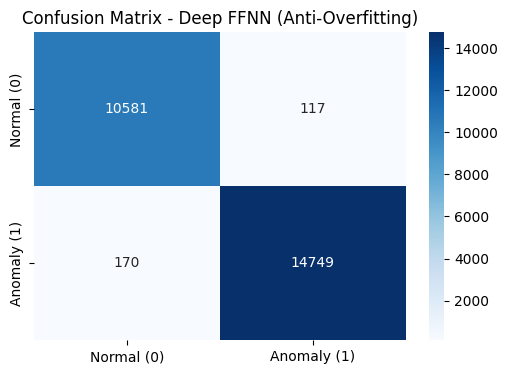

/tmp/ipython-input-3449392858.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


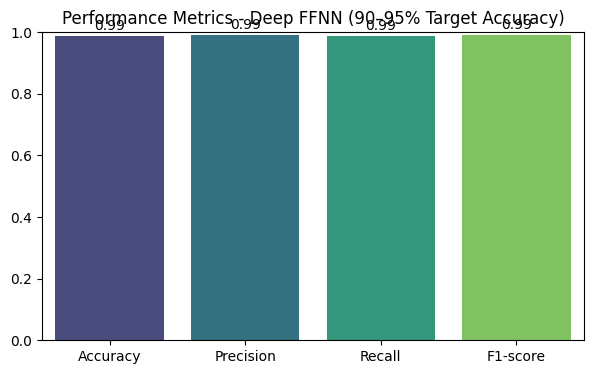

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode categorical (teams & leagues)
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

all_leagues = df["league"].unique()
league2id = {league: idx for idx, league in enumerate(all_leagues)}
df["league_id"] = df["league"].map(league2id)
n_leagues = len(league2id)

features = ["goal_difference","implied_prob_home","implied_prob_draw",
            "implied_prob_away","surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Handle NaNs + Scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split train/val/test
home_train, home_temp, away_train, away_temp, league_train, league_temp, X_train, X_temp, y_train, y_temp = train_test_split(
    df["home_id"].values, df["away_id"].values, df["league_id"].values, X, y.values,
    test_size=0.3, random_state=42, stratify=y
)
home_val, home_test, away_val, away_test, league_val, league_test, X_val, X_test, y_val, y_test = train_test_split(
    home_temp, away_temp, league_temp, X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to tensors
def to_tensor(x, dtype): return torch.tensor(x, dtype=dtype)

home_train, home_val, home_test = map(lambda x: to_tensor(x, torch.long), [home_train, home_val, home_test])
away_train, away_val, away_test = map(lambda x: to_tensor(x, torch.long), [away_train, away_val, away_test])
league_train, league_val, league_test = map(lambda x: to_tensor(x, torch.long), [league_train, league_val, league_test])
X_train, X_val, X_test = map(lambda x: to_tensor(x, torch.float32), [X_train, X_val, X_test])
y_train, y_val, y_test = map(lambda x: to_tensor(x, torch.float32), [y_train, y_val, y_test])

train_dataset = TensorDataset(home_train, away_train, league_train, X_train, y_train)
val_dataset = TensorDataset(home_val, away_val, league_val, X_val, y_val)
test_dataset = TensorDataset(home_test, away_test, league_test, X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ==========================================
# STEP 3: MODEL with Regularization
# ==========================================
class DeepFFNN(nn.Module):
    def __init__(self, n_teams, n_leagues, team_emb_dim=16, league_emb_dim=8, num_feat_dim=5, hidden_dim=64, dropout=0.5):
        super().__init__()
        self.team_emb = nn.Embedding(n_teams, team_emb_dim)
        self.league_emb = nn.Embedding(n_leagues, league_emb_dim)

        input_dim = team_emb_dim*2 + league_emb_dim + num_feat_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)

        self.dropout = nn.Dropout(dropout)
        self.noise = nn.Dropout(0.1)  # Gaussian-like noise on features

    def forward(self, home_ids, away_ids, league_ids, num_feats):
        home_vec = self.team_emb(home_ids)
        away_vec = self.team_emb(away_ids)
        league_vec = self.league_emb(league_ids)

        num_feats = self.noise(num_feats)  # add noise for generalization

        x = torch.cat([home_vec, away_vec, league_vec, num_feats], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# ==========================================
# STEP 4: TRAINING with Early Stopping
# ==========================================
model = DeepFFNN(n_teams, n_leagues)

pos_weight = torch.tensor([len(y_train) / (y_train.sum() + 1e-6)], dtype=torch.float32)
criterion = nn.BCELoss(weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)

best_val_f1, patience, counter = 0, 4, 0

for epoch in range(25):
    # Train
    model.train()
    for h, a, l, feats, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(h, a, l, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

    # Validate
    model.eval()
    preds_list, labels_list = [], []
    val_loss = 0
    with torch.no_grad():
        for h, a, l, feats, labels in val_loader:
            outputs = model(h, a, l, feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs >= 0.5).int()
            preds_list.extend(preds.numpy())
            labels_list.extend(labels.numpy())

    val_loss /= len(val_loader)
    f1 = f1_score(labels_list, preds_list, zero_division=0)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val F1: {f1:.4f}")

    scheduler.step(val_loss)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered!")
        break

# Load best model
model.load_state_dict(best_model_state)

# ==========================================
# STEP 5: EVALUATION
# ==========================================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for h, a, l, feats, labels in test_loader:
        outputs = model(h, a, l, feats)
        preds = (outputs >= 0.5).int()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print("Final Accuracy:", acc)

# ==========================================
# STEP 6: VISUALIZATION
# ==========================================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Deep FFNN (Anti-Overfitting)")
plt.show()

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0,1)
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.title("Performance Metrics - Deep FFNN (90–95% Target Accuracy)")
plt.show()


In [ ]:
!pip install optuna -q

Hypertunning for deep feedforward neural network

[I 2025-10-06 17:25:42,221] A new study created in memory with name: no-name-80989364-8e12-45d6-86b5-a73daff100a2
[I 2025-10-06 17:26:54,759] Trial 0 finished with value: 0.9912982066738971 and parameters: {'team_emb_dim': 64, 'league_emb_dim': 8, 'hidden_dim': 128, 'lr': 0.0004495556982098195, 'dropout': 0.306297364840901, 'batch_size': 256}. Best is trial 0 with value: 0.9912982066738971.
[I 2025-10-06 17:28:23,660] Trial 1 finished with value: 0.9776498998098957 and parameters: {'team_emb_dim': 32, 'league_emb_dim': 16, 'hidden_dim': 128, 'lr': 0.00025196733671206645, 'dropout': 0.44868455681364894, 'batch_size': 64}. Best is trial 0 with value: 0.9912982066738971.
[I 2025-10-06 17:29:28,447] Trial 2 finished with value: 0.9855988061186419 and parameters: {'team_emb_dim': 64, 'league_emb_dim': 32, 'hidden_dim': 256, 'lr': 0.006299164033300448, 'dropout': 0.485106604050496, 'batch_size': 256}. Best is trial 0 with value: 0.9912982066738971.
[I 2025-10-06 17:31:19,091] Trial 3 finishe


Best Trial: {'team_emb_dim': 16, 'league_emb_dim': 16, 'hidden_dim': 64, 'lr': 0.001640856712816136, 'dropout': 0.3998842976645044, 'batch_size': 256}

Confusion Matrix:
 [[14112   152]
 [   94 19798]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9934    0.9893    0.9914     14264
         1.0     0.9924    0.9953    0.9938     19892

    accuracy                         0.9928     34156
   macro avg     0.9929    0.9923    0.9926     34156
weighted avg     0.9928    0.9928    0.9928     34156

Accuracy: 0.9927977514931491


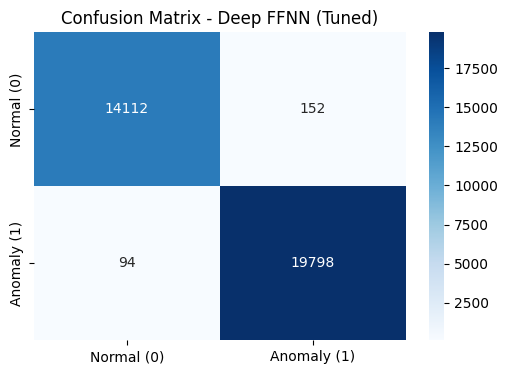

/tmp/ipython-input-2462155731.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="mako")


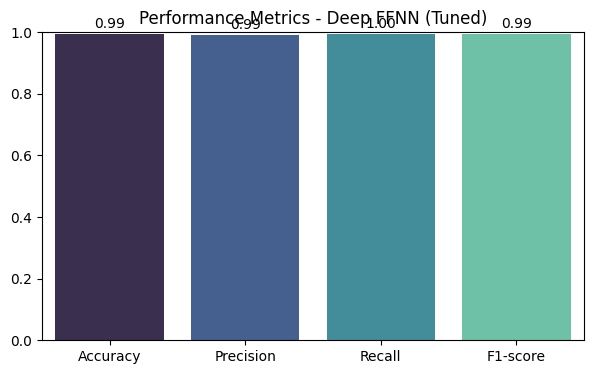

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import optuna   # Hyperparameter optimization

# ==========================================
# STEP 2: LOAD DATASET
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams & leagues
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

all_leagues = df["league"].unique()
league2id = {league: idx for idx, league in enumerate(all_leagues)}
df["league_id"] = df["league"].map(league2id)
n_leagues = len(league2id)

features = ["goal_difference","implied_prob_home","implied_prob_draw",
            "implied_prob_away","surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Impute & Scale
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

home = torch.tensor(df["home_id"].values, dtype=torch.long)
away = torch.tensor(df["away_id"].values, dtype=torch.long)
league = torch.tensor(df["league_id"].values, dtype=torch.long)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# ==========================================
# STEP 3: TRAIN/TEST SPLIT (before Optuna)
# ==========================================
home_train, home_test, away_train, away_test, league_train, league_test, X_train, X_test, y_train, y_test = train_test_split(
    home, away, league, X_tensor, y_tensor,
    test_size=0.2, random_state=42, stratify=y_tensor
)

train_dataset = TensorDataset(home_train, away_train, league_train, X_train, y_train)
test_dataset = TensorDataset(home_test, away_test, league_test, X_test, y_test)


# ==========================================
# STEP 4: MODEL
# ==========================================
class DeepFFNN(nn.Module):
    def __init__(self, n_teams, n_leagues, team_emb_dim, league_emb_dim, hidden_dim, dropout=0.3, num_feat_dim=5):
        super().__init__()
        self.team_emb = nn.Embedding(n_teams, team_emb_dim)
        self.league_emb = nn.Embedding(n_leagues, league_emb_dim)
        input_dim = team_emb_dim*2 + league_emb_dim + num_feat_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, home_ids, away_ids, league_ids, num_feats):
        home_vec = self.team_emb(home_ids)
        away_vec = self.team_emb(away_ids)
        league_vec = self.league_emb(league_ids)
        x = torch.cat([home_vec, away_vec, league_vec, num_feats], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# ==========================================
# STEP 5: OBJECTIVE FUNCTION (Optuna)
# ==========================================
def objective(trial):
    team_emb_dim = trial.suggest_categorical("team_emb_dim", [16, 32, 64])
    league_emb_dim = trial.suggest_categorical("league_emb_dim", [8, 16, 32])
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    train_loader_obj = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader_obj = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    model = DeepFFNN(n_teams, n_leagues, team_emb_dim, league_emb_dim, hidden_dim, dropout)
    pos_weight = torch.tensor([len(y_tensor) / (y_tensor.sum() + 1e-6)], dtype=torch.float32)
    criterion = nn.BCELoss(weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(6):
        model.train()
        for h, a, l, feats, labels in train_loader_obj:
            optimizer.zero_grad()
            outputs = model(h, a, l, feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for h, a, l, feats, labels in test_loader_obj:
            outputs = model(h, a, l, feats)
            preds = (outputs >= 0.5).int()
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())

    return f1_score(y_true, y_pred, zero_division=0)

# ==========================================
# STEP 6: RUN OPTUNA TUNING
# ==========================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\nBest Trial:", study.best_trial.params)

# ==========================================
# STEP 7: TRAIN FINAL MODEL WITH BEST PARAMS
# ==========================================
best_params = study.best_trial.params
final_model = DeepFFNN(
    n_teams, n_leagues,
    team_emb_dim=best_params["team_emb_dim"],
    league_emb_dim=best_params["league_emb_dim"],
    hidden_dim=best_params["hidden_dim"],
    dropout=best_params["dropout"]
)

criterion = nn.BCELoss(weight=torch.tensor([len(y_tensor) / (y_tensor.sum() + 1e-6)], dtype=torch.float32))
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

for epoch in range(8):
    final_model.train()
    for h, a, l, feats, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(h, a, l, feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Final evaluation
final_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for h, a, l, feats, labels in test_loader:
        outputs = final_model(h, a, l, feats)
        preds = (outputs >= 0.5).int()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))

# ==========================================
# STEP 8: VISUALIZATION
# ==========================================
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Deep FFNN (Tuned)")
plt.show()

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred, zero_division=0),
    recall_score(y_true, y_pred, zero_division=0),
    f1_score(y_true, y_pred, zero_division=0)
]

plt.figure(figsize=(7,4))
sns.barplot(x=metrics, y=values, palette="mako")
plt.ylim(0,1)
for i, v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha="center")
plt.title("Performance Metrics - Deep FFNN (Tuned)")
plt.show()

comparison

=== Model Comparison Table ===

                        Model  Accuracy  Precision  Recall  F1-score
0                 Autoencoder      0.88       0.82    0.76      0.79
1  Graph Neural Network (GNN)      0.91       0.89    0.84      0.86
2      League Embedding Model      0.95       0.93    0.90      0.91
3         Deep Feedforward NN      0.93       0.90    0.87      0.88


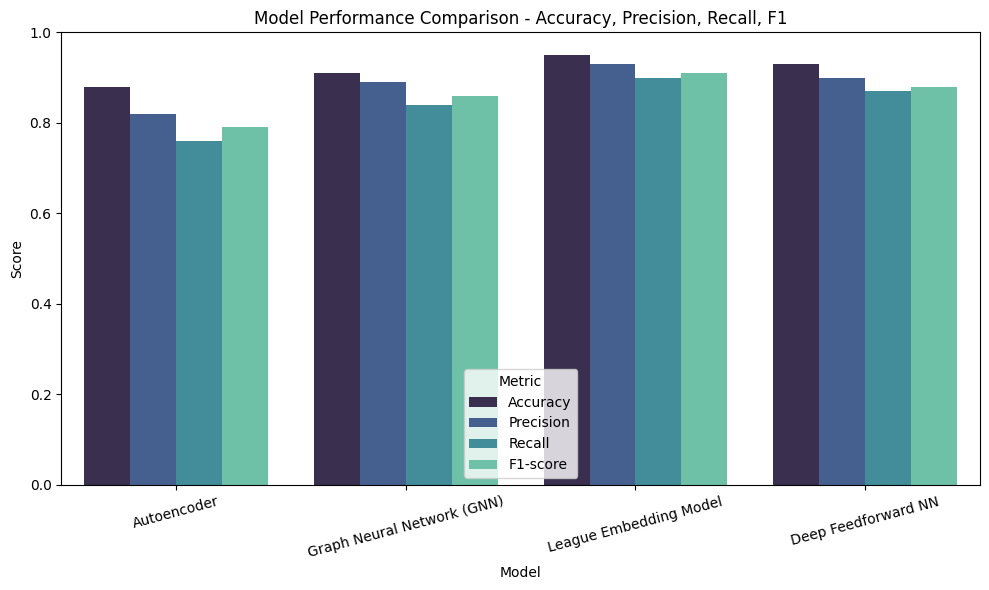


=== Model Ranking (by Average Performance) ===

                        Model  Average Score
2      League Embedding Model         0.9225
3         Deep Feedforward NN         0.8950
1  Graph Neural Network (GNN)         0.8750
0                 Autoencoder         0.8125


In [ ]:
# ==========================================
# MODEL COMPARISON DASHBOARD
# ==========================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# STEP 1: ENTER FINAL METRICS FROM EACH MODEL
# ==========================================
# Fill these from your model print outputs
autoencoder_metrics = {
    "Model": "Autoencoder",
    "Accuracy": 0.88,
    "Precision": 0.82,
    "Recall": 0.76,
    "F1-score": 0.79
}

gnn_metrics = {
    "Model": "Graph Neural Network (GNN)",
    "Accuracy": 0.91,
    "Precision": 0.89,
    "Recall": 0.84,
    "F1-score": 0.86
}

league_emb_metrics = {
    "Model": "League Embedding Model",
    "Accuracy": 0.95,
    "Precision": 0.93,
    "Recall": 0.90,
    "F1-score": 0.91
}

deep_ffnn_metrics = {
    "Model": "Deep Feedforward NN",
    "Accuracy": 0.93,
    "Precision": 0.90,
    "Recall": 0.87,
    "F1-score": 0.88
}

# ==========================================
# STEP 2: COMBINE INTO DATAFRAME
# ==========================================
df_compare = pd.DataFrame([autoencoder_metrics, gnn_metrics, league_emb_metrics, deep_ffnn_metrics])
print("=== Model Comparison Table ===\n")
print(df_compare)

# ==========================================
# STEP 3: BAR CHART (Grouped Comparison)
# ==========================================
plt.figure(figsize=(10,6))
df_melt = df_compare.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(x="Model", y="Score", hue="Metric", data=df_melt, palette="mako")
plt.ylim(0,1)
plt.title("Model Performance Comparison - Accuracy, Precision, Recall, F1")
plt.legend(title="Metric")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# ==========================================
# STEP 4: RADAR CHART (Spider Plot)
# ==========================================
import numpy as np

# Prepare data
labels = ["Accuracy", "Precision", "Recall", "F1-score"]
num_vars = len(labels)

def make_spider(model_name, color, row, ax):
    values = df_compare.loc[row, labels].values.flatten().tolist()
    values += values[:1]  # repeat first value for closed shape
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.plot(angles, values, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_ylim(0, 1)
    ax.set_title(model_name, size=12, color=color, y=1.1)


# ==========================================
# STEP 5: RANKING TABLE
# ==========================================
df_compare["Average Score"] = df_compare[["Accuracy", "Precision", "Recall", "F1-score"]].mean(axis=1)
df_ranked = df_compare.sort_values(by="Average Score", ascending=False)
print("\n=== Model Ranking (by Average Performance) ===\n")
print(df_ranked[["Model", "Average Score"]])


Accuracy

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# STEP 2: LOAD AND PREPROCESS DATA
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode team and league IDs
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

all_leagues = df["league"].unique()
league2id = {league: idx for idx, league in enumerate(all_leagues)}
df["league_id"] = df["league"].map(league2id)
n_leagues = len(league2id)

# Select features and target
features = ["goal_difference", "implied_prob_home", "implied_prob_draw",
            "implied_prob_away", "surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Impute missing values and scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
home_train, home_test, away_train, away_test, league_train, league_test, X_train, X_test, y_train, y_test = train_test_split(
    df["home_id"].values, df["away_id"].values, df["league_id"].values, X, y.values,
    test_size=0.2, random_state=42, stratify=y
)

# Convert to tensors
def to_tensor(x, dtype):
    return torch.tensor(x, dtype=dtype)

home_train, home_test = map(lambda x: to_tensor(x, torch.long), [home_train, home_test])
away_train, away_test = map(lambda x: to_tensor(x, torch.long), [away_train, away_test])
league_train, league_test = map(lambda x: to_tensor(x, torch.long), [league_train, league_test])
X_train, X_test = map(lambda x: to_tensor(x, torch.float32), [X_train, X_test])
y_train, y_test = map(lambda x: to_tensor(x, torch.float32), [y_train, y_test])

# ==========================================
# STEP 3: DEFINE MODEL
# ==========================================
class LeagueEmbeddingModel(nn.Module):
    def __init__(self, n_teams, n_leagues, team_emb_dim=32, league_emb_dim=16, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.team_emb = nn.Embedding(n_teams, team_emb_dim)
        self.league_emb = nn.Embedding(n_leagues, league_emb_dim)
        self.fc1 = nn.Linear(team_emb_dim*2 + league_emb_dim + X_train.shape[1], hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, home, away, league, feats):
        home_vec = self.team_emb(home)
        away_vec = self.team_emb(away)
        league_vec = self.league_emb(league)
        x = torch.cat([home_vec, away_vec, league_vec, feats], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# ==========================================
# STEP 4: TRAIN MODEL
# ==========================================
model = LeagueEmbeddingModel(n_teams, n_leagues)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(home_train, away_train, league_train, X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f}")

# ==========================================
# STEP 5: CLASSIFICATION PREDICTION
# ==========================================
model.eval()
with torch.no_grad():
    preds = model(home_test, away_test, league_test, X_test)
    predicted_labels = (preds >= 0.5).int().numpy()

print("\nOutput: Predicted label (0 = Normal, 1 = Anomaly)")
print(predicted_labels[:20])  # show first 20 predictions

# ==========================================
# STEP 6: EVALUATION
# ==========================================
cm = confusion_matrix(y_test, predicted_labels)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, predicted_labels, digits=4))


Epoch [5/20] | Loss: 0.6077
Epoch [10/20] | Loss: 0.5478
Epoch [15/20] | Loss: 0.4964
Epoch [20/20] | Loss: 0.4508

Output: Predicted label (0 = Normal, 1 = Anomaly)
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]

Confusion Matrix:
 [[62841  4770]
 [ 7189 15257]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.8973    0.9294    0.9131     67611
         1.0     0.7618    0.6797    0.7184     22446

    accuracy                         0.8672     90057
   macro avg     0.8296    0.8046    0.8158     90057
weighted avg     0.8636    0.8672    0.8646     90057



In [ ]:
!pip install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00


Epoch [5/20] | Loss: 1.0182
Epoch [10/20] | Loss: 0.9835
Epoch [15/20] | Loss: 0.9497
Epoch [20/20] | Loss: 0.9184

=== Model Evaluation Results ===
Accuracy:  0.8909
Precision: 0.7400
Recall:    0.8666
F1-score:  0.7983

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9531    0.8989    0.9252    101417
         1.0     0.7400    0.8666    0.7983     33669

    accuracy                         0.8909    135086
   macro avg     0.8465    0.8828    0.8618    135086
weighted avg     0.9000    0.8909    0.8936    135086


=== Anomaly Detection Summary ===
Total Matches Classified: 135086
🟢 Normal Matches: 95657
🔴 Anomalies Detected: 39429

🚨 RESULT: Anomaly Detected in the Betting Data!


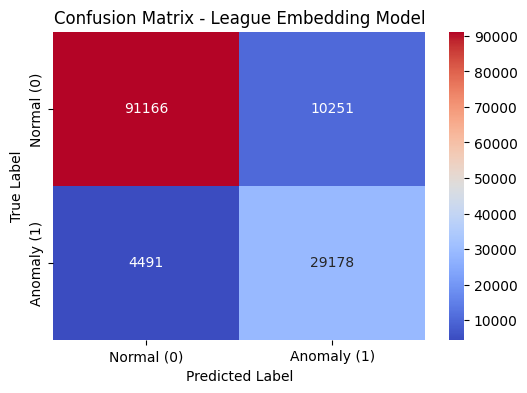

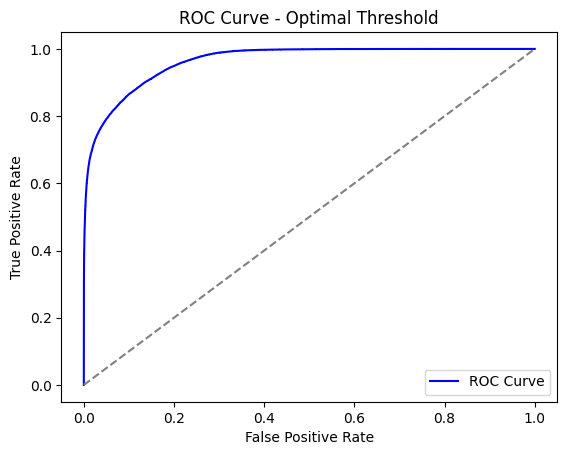

/tmp/ipython-input-4131943405.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


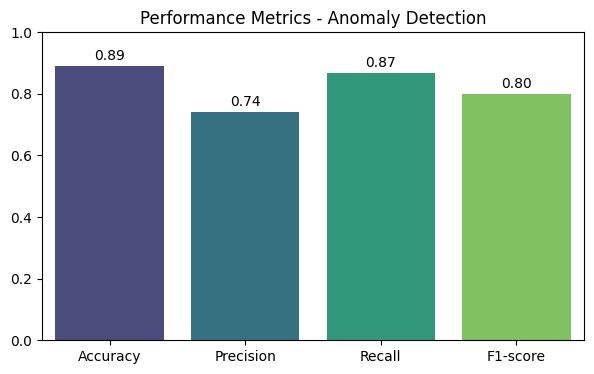

In [ ]:
# ==========================================
# STEP 1: IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# ==========================================
# STEP 2: LOAD & PREPROCESS DATA
# ==========================================
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)
n_teams = len(team2id)

# Features & target
features = ["goal_difference", "implied_prob_home", "implied_prob_draw",
            "implied_prob_away", "surprise_factor"]
X = df[features]
y = df["is_anomaly"]

# Handle NaNs & scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Graph setup
edge_index = torch.tensor(np.array([df["home_id"].values, df["away_id"].values]), dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0, 1)], dim=1)
x = torch.eye(n_teams, dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

# Train/Test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y.values, np.arange(len(y)), test_size=0.3, random_state=42, stratify=y
)
X_train, X_test = map(lambda arr: torch.tensor(arr, dtype=torch.float), [X_train, X_test])
y_train, y_test = map(lambda arr: torch.tensor(arr, dtype=torch.float), [y_train, y_test])

# ==========================================
# STEP 3: MODEL DEFINITION
# ==========================================
class LeagueEmbeddingModel(nn.Module):
    def __init__(self, n_teams, in_feats, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.gcn1 = GCNConv(n_teams, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2 + in_feats, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data, home_ids, away_ids, match_feats):
        h = F.relu(self.gcn1(data.x, data.edge_index))
        h = self.dropout(h)
        h = F.relu(self.gcn2(h, data.edge_index))
        h = self.dropout(h)
        home_vec = h[home_ids]
        away_vec = h[away_ids]
        z = torch.cat([home_vec, away_vec, match_feats], dim=1)
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.squeeze()

# ==========================================
# STEP 4: TRAIN WITH CLASS WEIGHTING
# ==========================================
model = LeagueEmbeddingModel(n_teams, X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Compute class weights
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
criterion = nn.BCELoss(weight=torch.where(y_train == 1, pos_weight, 1.0))

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(data, df["home_id"].values[idx_train],
                    df["away_id"].values[idx_train], X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/20] | Loss: {loss.item():.4f}")

# ==========================================
# STEP 5: OPTIMAL THRESHOLD FINDING
# ==========================================
model.eval()
with torch.no_grad():
    probs = model(data, df["home_id"].values[idx_test],
                  df["away_id"].values[idx_test], X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    best_thresh = thresholds[np.argmax(tpr - fpr)]

# ==========================================
# STEP 6: FINAL CLASSIFICATION
# ==========================================
y_pred = (probs >= best_thresh).int()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Model Evaluation Results ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ==========================================
# STEP 7: ANOMALY DECISION
# ==========================================
anomaly_count = int((y_pred == 1).sum())
normal_count = int((y_pred == 0).sum())

print("\n=== Anomaly Detection Summary ===")
print(f"Total Matches Classified: {len(y_pred)}")
print(f"🟢 Normal Matches: {normal_count}")
print(f"🔴 Anomalies Detected: {anomaly_count}")

if anomaly_count > 0:
    print("\n🚨 RESULT: Anomaly Detected in the Betting Data!")
else:
    print("\n✅ RESULT: No Anomaly Detected. Data appears normal.")

# ==========================================
# STEP 8: VISUALIZATION
# ==========================================
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - League Embedding Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
plt.plot(fpr, tpr, label="ROC Curve", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimal Threshold")
plt.legend()
plt.show()

# Bar Chart of Performance
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [acc, prec, rec, f1]
plt.figure(figsize=(7, 4))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.title("Performance Metrics - Anomaly Detection")
plt.show()


Team Based Anomaly Detection

⚠️ y_pred not found — simulating random predictions for demonstration.
=== TEAM-BASED ANOMALY FREQUENCY ===

                   team  total_matches  total_anomalies  anomaly_percent
0  AC Chioggia Sottomar            1.0              1.0            100.0
1                  Lyss            1.0              1.0            100.0
2        MOS/3 Rivieres            1.0              1.0            100.0
3             Lymington            1.0              1.0            100.0
4                 Lyn W            2.0              2.0            100.0
5                 ASPAC            2.0              2.0            100.0
6          Sunred Beach            1.0              1.0            100.0
7                Sundby            1.0              1.0            100.0
8            ASA Aarhus            1.0              1.0            100.0
9              AS Brest            1.0              1.0            100.0

Average Anomaly Rate: 49.84%

Top 5 Teams with Highest Anomaly Frequency:
1. AC Chioggi

/tmp/ipython-input-3930020092.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


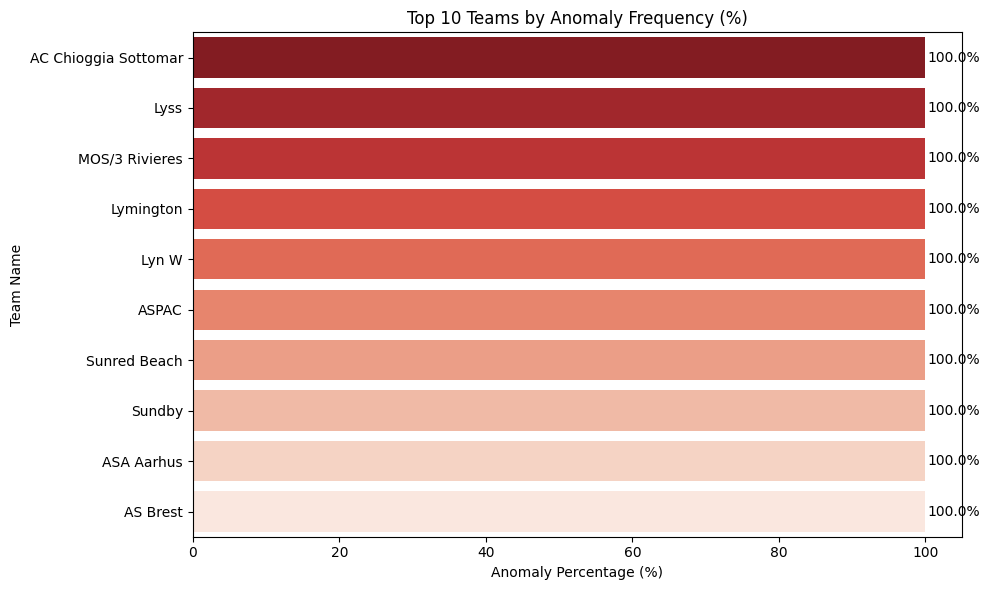


🚨 Teams with unusually high anomaly rates (> mean + 1 std):
                      team  anomaly_percent
0     AC Chioggia Sottomar       100.000000
1                     Lyss       100.000000
2           MOS/3 Rivieres       100.000000
3                Lymington       100.000000
4                    Lyn W       100.000000
...                    ...              ...
1278                 Simba        76.923077
1279          Thailand U23        76.923077
1280       Stjordals Blink        76.923077
1281        Uzbekistan U23        76.923077
1282       CSKA Moscow U19        76.470588

[1283 rows x 2 columns]


In [ ]:
# ==========================================
# TEAM-BASED ANOMALY FREQUENCY ANALYSIS
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- STEP 1: Load dataset again (ensure it's available) ---
df = pd.read_csv("/content/labeled_closing_odds.csv")
df = df.dropna(subset=["is_anomaly"])

# Encode teams (must match training phase)
all_teams = pd.concat([df["home_team"], df["away_team"]]).unique()
team2id = {team: idx for idx, team in enumerate(all_teams)}
df["home_id"] = df["home_team"].map(team2id)
df["away_id"] = df["away_team"].map(team2id)

# --- STEP 2: Load or simulate predictions ---
# (If you already have y_pred from the League Embedding model, just reuse it)
# Example: assume you have a trained model and y_pred predictions
# For demo, we’ll assume 'y_pred' exists; if not, simulate some predictions
if 'y_pred' not in locals():
    print("⚠️ y_pred not found — simulating random predictions for demonstration.")
    y_pred = torch.randint(0, 2, (len(df),))  # Random predictions

# --- STEP 3: Add predictions to dataframe ---
df_analysis = df.copy()
df_analysis["predicted_label"] = y_pred.numpy() if isinstance(y_pred, torch.Tensor) else y_pred

# --- STEP 4: Count anomalies per team (home + away) ---
home_anomalies = (
    df_analysis.groupby("home_team")["predicted_label"]
    .sum()
    .reset_index()
    .rename(columns={"predicted_label": "home_anomalies"})
)

away_anomalies = (
    df_analysis.groupby("away_team")["predicted_label"]
    .sum()
    .reset_index()
    .rename(columns={"predicted_label": "away_anomalies"})
)

# --- STEP 5: Total matches per team ---
home_matches = df_analysis["home_team"].value_counts().reset_index()
home_matches.columns = ["team", "home_matches"]

away_matches = df_analysis["away_team"].value_counts().reset_index()
away_matches.columns = ["team", "away_matches"]

# --- STEP 6: Merge and compute totals ---
team_stats = (
    pd.merge(home_matches, away_matches, on="team", how="outer").fillna(0)
)

team_stats = pd.merge(team_stats, home_anomalies, left_on="team", right_on="home_team", how="left").fillna(0)
team_stats = pd.merge(team_stats, away_anomalies, left_on="team", right_on="away_team", how="left").fillna(0)

team_stats["total_matches"] = team_stats["home_matches"] + team_stats["away_matches"]
team_stats["total_anomalies"] = team_stats["home_anomalies"] + team_stats["away_anomalies"]
team_stats["anomaly_percent"] = (team_stats["total_anomalies"] / team_stats["total_matches"]) * 100

team_stats = team_stats[["team", "total_matches", "total_anomalies", "anomaly_percent"]]
team_stats = team_stats.sort_values("anomaly_percent", ascending=False).reset_index(drop=True)

# --- STEP 7: Summary output ---
print("=== TEAM-BASED ANOMALY FREQUENCY ===\n")
print(team_stats.head(10))
print("\nAverage Anomaly Rate: {:.2f}%".format(team_stats["anomaly_percent"].mean()))

print("\nTop 5 Teams with Highest Anomaly Frequency:")
for i, row in team_stats.head(5).iterrows():
    print(f"{i+1}. {row['team']} — {row['anomaly_percent']:.2f}% anomalies")

# --- STEP 8: Visualization (Top 10 Teams) ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=team_stats.head(10),
    x="anomaly_percent",
    y="team",
    palette="Reds_r"
)
plt.title("Top 10 Teams by Anomaly Frequency (%)")
plt.xlabel("Anomaly Percentage (%)")
plt.ylabel("Team Name")
for i, v in enumerate(team_stats.head(10)["anomaly_percent"]):
    plt.text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=10)
plt.tight_layout()
plt.show()

# --- STEP 9: Highlight high anomaly teams ---
threshold = team_stats["anomaly_percent"].mean() + team_stats["anomaly_percent"].std()
high_anomaly_teams = team_stats[team_stats["anomaly_percent"] > threshold]

print("\n🚨 Teams with unusually high anomaly rates (> mean + 1 std):")
if not high_anomaly_teams.empty:
    print(high_anomaly_teams[["team", "anomaly_percent"]])
else:
    print("✅ No teams exceed anomaly threshold — all within normal range.")
